In [1]:
import numpy as np
import operator
import random
from src.simulation.simulator import Simulator
from src.simulation.networks import STAR_9S_2L_01
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
import statistics
from IPython.display import display, clear_output
import pickle
import timeit



# Experiment Results Plot

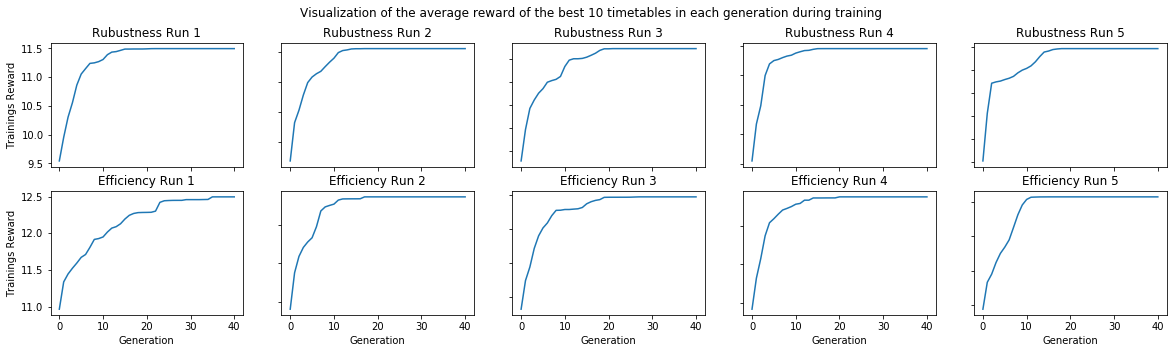

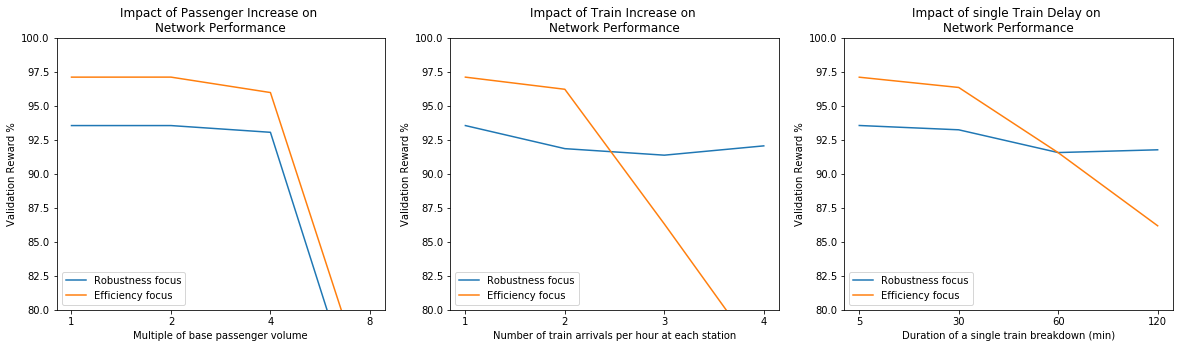

In [2]:
experiment = 'star9s_2l'
file_eff = open('../../raw_results/star9s_exp1_eff', 'rb')
file_rob = open('../../raw_results/star9s_exp1_rob', 'rb')

# dump information to that file
robust_runs = pickle.load(file_rob)
efficency_runs = pickle.load(file_eff)

file_eff.close()
file_rob.close()

##############################33

fig, axs = plt.subplots(2, 5, figsize=(20, 5))
for i in range(5):
    pop_avg_over_time = []
    for generation in robust_runs[i]:
        avg = statistics.mean([member[1] for member in generation[0:10]])
        pop_avg_over_time.append(avg)
    
    axs[0][i].plot(pop_avg_over_time)
    axs[0][i].set_title('Rubustness Run {}'.format(i+1))
    
    pop_avg_over_time = []
    for generation in efficency_runs[i]:
        avg = statistics.mean([member[1] for member in generation[0:10]])
        pop_avg_over_time.append(avg)
    
    axs[1][i].plot(pop_avg_over_time)
    axs[1][i].set_title('Efficiency Run {}'.format(i+1))
    
for ax in axs.flat:
    ax.set(xlabel='Generation', ylabel='Trainings Reward')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
fig.suptitle('Visualization of the average reward of the best 10 timetables in each generation during training')
fig.savefig('{}_{}.png'.format(experiment, 'training'))

####################
def helper_reward_plot(data_list, keyword, run):
    return [statistics.mean([ el[i] for el in [list(item[2][keyword].values()) for item in data_list[run][-1][:5]]]) for i in range(4)]

def plot_figure(ax, data_eff, data_rob, title, x_ticklables, x_lable=''):
    ax.plot([statistics.mean([ 100*i[j]/3 for i in data_rob]) for j in range(len(data_rob[0]))], label="Robustness focus")
    ax.plot([statistics.mean([ 100*i[j]/3 for i in data_eff]) for j in range(len(data_eff[0]))], label="Efficiency focus")
    ax.legend(loc="lower left")
    ax.set_ylabel('Validation Reward %')
    ax.set_xlabel(x_lable)
    ax.set_title(title)
    ax.set_ylim([80,100])
    ax.set_xticks(list(range(4)))
    ax.set_xticklabels(x_ticklables)
    
    

eff_rewards_pass = []
rob_rewards_pass = []

eff_reward_train = []
rob_reward_train = []

eff_reward_delay = []
rob_reward_delay = []

for run in range(len(robust_runs)):

    rob_rewards_pass.append(helper_reward_plot(robust_runs, 'passenger_increase', run))
    eff_rewards_pass.append(helper_reward_plot(efficency_runs, 'passenger_increase', run))
    
    rob_reward_train.append(helper_reward_plot(robust_runs, 'trains_increase', run))
    eff_reward_train.append(helper_reward_plot(efficency_runs, 'trains_increase', run))
    
    rob_reward_delay.append(helper_reward_plot(robust_runs, 'trains_delay', run))
    eff_reward_delay.append(helper_reward_plot(efficency_runs, 'trains_delay', run))
    

fig = plt.figure(figsize=(20,5))
ax = []
ax.append(fig.add_subplot(1, 3, 1))
ax.append(fig.add_subplot(1, 3, 2))
ax.append(fig.add_subplot(1, 3, 3))

plot_figure(ax[0], eff_rewards_pass, rob_rewards_pass, 'Impact of Passenger Increase on \nNetwork Performance', ['1','2','4','8'], 'Multiple of base passenger volume')

plot_figure(ax[1], eff_reward_train, rob_reward_train, 'Impact of Train Increase on \nNetwork Performance', ['1','2','3','4'], 'Number of train arrivals per hour at each station')

plot_figure(ax[2], eff_reward_delay, rob_reward_delay, 'Impact of single Train Delay on \nNetwork Performance', ['5','30','60','120'], 'Duration of a single train breakdown (min)')


fig.savefig('{}_{}.png'.format(experiment, 'results'))

# Genetic Algorithm Implementation and Experiment Setup

In [ ]:
NETWORK = STAR_9S_2L_01
RANGE_TT = [0, 240]

# Following Probabilities have to sum up to 1.0
PROBABILITY_NOCHANGE = 0.2
PROBABILITY_CROSSOVER = 0.4
PROBABILITY_RANDOM = 0.1
PROBABILITY_SWAP = 0.3

# Seperate from above probabilites
PROBABILITY_MUT = 0.1

In [ ]:
def crossover(chromo_1: [], chromo_2: [], crossover_point: int):
    
    if not crossover_point < len(chromo_1):
        raise ValueError("Crossover Point has to be smaller than the number of Elements in the Chromosome")
    if len(chromo_1) != len(chromo_2):
        raise ValueError("Chromosomes to crossover have to have the same length. len(Chromo1): {}, len(Chromo2): {}".format(len(chromo_1), len(chromo_2)))
    
    child_1 = chromo_1[:crossover_point] + chromo_2[crossover_point:]
    child_2 = chromo_2[:crossover_point] + chromo_1[crossover_point:]
    
    return child_1, child_2


def crossover_center(chromo_1: [], chromo_2: [], crossover_interval: []):
    if len(crossover_interval) != 2:
        raise ValueError("Crossover Interval has to consist of 2 values (from, to)")
    if crossover_interval[0] > crossover_interval[1]:
        raise ValueError("First Element has to be smaller than second element")
        
    child_1 = chromo_1[:crossover_interval[0]] + chromo_2[crossover_interval[0]:crossover_interval[1]] + chromo_1[crossover_interval[1]:]
    child_2 = chromo_2[:crossover_interval[0]] + chromo_1[crossover_interval[0]:crossover_interval[1]] + chromo_2[crossover_interval[1]:]
    
    child_1.sort()
    child_2.sort()
    
    return child_1, child_2


def mutate(chromo: [], position: int, deviation: int):
    if not position < len(chromo):
        raise IndexError("Position Index out of range for the given Chromosome")
    
    # Static Value Below (0, 240)
    chromo[position] = min(max(RANGE_TT[0], int(np.random.normal(chromo[position], deviation))), RANGE_TT[1])
    return chromo


In [ ]:
def calc_total_reward_from_results(results, timetables):
    weigth_mat = WEIGTH_MAT
    
    w_passenger_reward = calc_weighted_reward(list(results['passenger_increase'].values())[0:4], weigth_mat)
    w_train_reward = calc_weighted_reward(list(results['trains_increase'].values())[0:4], weigth_mat)
    w_delay_reward = calc_weighted_reward(list(results['trains_delay'].values())[0:4], weigth_mat)
    
    length_reward = 0
    for tt in timetables:
        length_reward += 0.5*(1.0 - tt[-1]/RANGE_TT[1])/2 + 0.5*(1.0 - (tt[int(len(tt)/2)]-tt[int(len(tt)/2)-1])/60.0)
            
    total_reward = 1.0*w_passenger_reward + 1.0*w_train_reward + 2.0*w_delay_reward + length_reward
    
    return total_reward


def calc_weighted_reward(rewards, weigths):
    total_reward = 0
    for weight, reward in zip(weigths, rewards):
        total_reward += weight*reward
    
    return total_reward

In [ ]:
def generate_initial_population(population_size) -> []:
    sim = Simulator(NETWORK)
    future_collection = []
    population = []
    
    with ProcessPoolExecutor() as e:
        for _ in range(population_size):
            
            tt = []
            for line in NETWORK.LINES:
                count = 0
                for el in line[1]:
                    if str.startswith(el[0], 's'):
                        count += 1
    
                tt.append(sorted(list(np.random.randint(low=RANGE_TT[0], high=RANGE_TT[1], size=count))))
            
            
            future_collection.append((tt, e.submit(sim.evaluate_timetable, tt)))

        
        for timetable, future in future_collection:
            results = future.result()
            total_reward = calc_total_reward_from_results(results, timetable)
            population.append((timetable, total_reward, results))
        
    return population


def decimate_population(population: [], to_fraction: float = 0.1) -> []:
    population.sort(key = operator.itemgetter(1), reverse = True)
    if  0.0 > to_fraction > 1.0:
        raise ValueError("Fraction has to be in interval [0,1]")
    
    return population[0:int(to_fraction*len(population))]


def repopulate_population(population: [], goal_size: int) -> []:
    sim = Simulator(NETWORK)
    new_population = population[:]
    new_population_length = len(new_population)
    future_collection = []
    
    with ProcessPoolExecutor() as e:
        
        while new_population_length < goal_size:
                   
            parent_1, parent_2 = random.sample(population, 2)
            child_1 = []
            child_2 = []
            
            
            for chromo_1, chromo_2 in zip(parent_1[0].copy(), parent_2[0].copy()):
                
                randint = np.random.choice(4, 1, p=[PROBABILITY_NOCHANGE, 
                                                    PROBABILITY_CROSSOVER, 
                                                    PROBABILITY_RANDOM,
                                                    PROBABILITY_SWAP])
                if randint == 0:
                    pass
                elif randint == 1:
                    interval = list(np.random.choice(len(chromo_1)+1,2))
                    interval.sort()
                    chromo_1, chromo_2 = crossover_center(chromo_1, chromo_2, interval)
                elif randint == 2:
                    chromo_1 = sorted(list(np.random.randint(low=RANGE_TT[0], high=RANGE_TT[1], size=len(chromo_1))))
                    chromo_2 = sorted(list(np.random.randint(low=RANGE_TT[0], high=RANGE_TT[1], size=len(chromo_2))))
                elif randint == 3:
                    chromo_1, chromo_2 = chromo_2, chromo_1
                
                
                if np.random.randint(100) < int(PROBABILITY_MUT*100):
                    chromo_1 = mutate(chromo_1, np.random.randint(len(chromo_1)-1), 30)
                    chromo_1.sort()           
                    
                child_1.append(chromo_1)
                child_2.append(chromo_2)
                
            future_collection.append((child_1, e.submit(sim.evaluate_timetable, child_1)))
            future_collection.append((child_2, e.submit(sim.evaluate_timetable, child_2)))
            
            new_population_length+=2
        
        for timetable, future in future_collection:
            results = future.result()
            
            total_reward = calc_total_reward_from_results(results, timetable)
            new_population.append((timetable, total_reward, results))
            
        return new_population

## Training on robustness

In [ ]:
fig, ax = plt.subplots(1,2)
n_runs = 5
n_gens = 40

WEIGTH_MAT = [0.25, 0.25, 0.25, 0.25]
SAVEFILE_NAME = 'star9s_exp1_rob'

runs = []

time_per_run = []

for run in range(n_runs):
    start_run = timeit.default_timer()
    population = generate_initial_population(100)
    population.sort(key = operator.itemgetter(1), reverse = True)
    history = [population]
    
    
    for generation in range(n_gens):  
        start_gen = timeit.default_timer()
        
        population = decimate_population(population)
        population = repopulate_population(population, 100)
        population.sort(key = operator.itemgetter(1), reverse = True)
        history.append(population)
        
        stop_gen = timeit.default_timer()
        
        # Ploting
        clear_output(wait=True) 
        display("### Run {} - Generation {} ###".format(run, generation))
        
        pop_avg_over_time = []
        for generation in history:
            avg = statistics.mean([member[1] for member in generation[0:10]])
            pop_avg_over_time.append(avg)
        
        ax[0].cla()
        ax[1].cla()
        ax[0].plot(pop_avg_over_time)
        ax[1].plot([member[1] for member in population])
        
        
        display(plt.gcf())
        
        display("Time for Generation: {}s".format(stop_gen-start_gen))
        
        for i in range(6):
            display("Genome {:2} Score: {}".format(i, population[i][1]))
    
    
    stop_run = timeit.default_timer()
    time_per_run.append(stop_run-start_run)
    
    runs.append(history)
    

robust_runs = runs    
outfile = open(SAVEFILE_NAME,'wb')
pickle.dump(robust_runs,outfile)
outfile.close()

## Efficiency Run

In [ ]:
fig, ax = plt.subplots(1,2)
n_runs = 5
n_gens = 40

WEIGTH_MAT = [1.00, 0.00, 0.00, 0.00]
SAVEFILE_NAME = 'star9s_exp1_eff'

runs = []



for run in range(n_runs):
    population = generate_initial_population(100)
    population.sort(key = operator.itemgetter(1), reverse = True)
    history = [population]

    for generation in range(n_gens):  
        
        population = decimate_population(population)
        population = repopulate_population(population, 100)
        population.sort(key = operator.itemgetter(1), reverse = True)
        history.append(population)
        
        # Ploting
        
        clear_output(wait=True) 
        display("### Run {} - Generation {} ###".format(run, generation))
        
        pop_avg_over_time = []
        for generation in history:
            avg = statistics.mean([member[1] for member in generation[0:10]])
            pop_avg_over_time.append(avg)
        
        ax[0].cla()
        ax[1].cla()
        ax[0].plot(pop_avg_over_time)
        ax[1].plot([member[1] for member in population])
        
        
        display(plt.gcf())
        
        for i in range(6):
            display("Genome {:2} Score: {}".format(i, population[i][1]))
            
    runs.append(history)
    

efficency_runs = runs    
outfile = open(SAVEFILE_NAME,'wb')
pickle.dump(efficency_runs,outfile)
outfile.close()